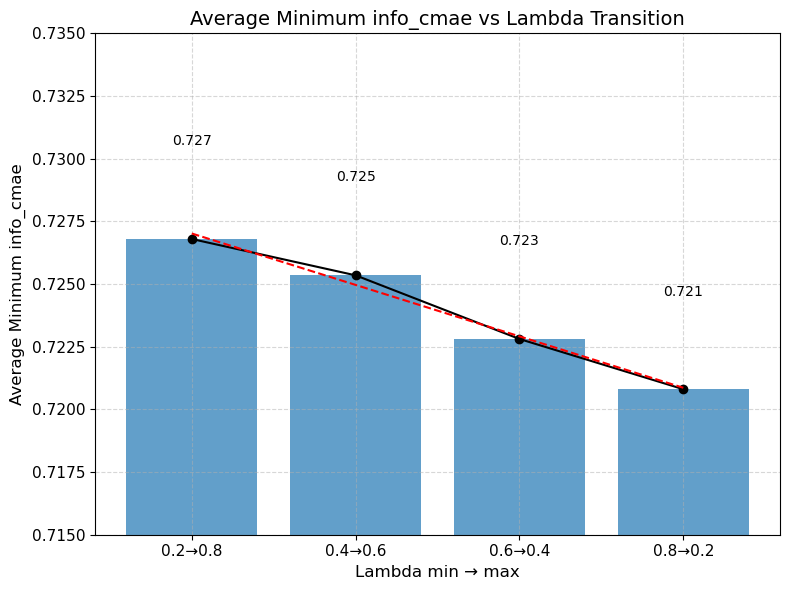

In [14]:
import os
import glob
import json
import numpy as np
import matplotlib.pyplot as plt

# Base directory
base_dir = "/proj/sourasb-220503/TCSS-DIPA2/Fed-DIPA2/results/client_level"

# (lambda_min, lambda_max) pairs
lambda_pairs = [(0.2, 0.8), (0.4, 0.6), (0.6, 0.4), (0.8, 0.2)]
folder_template = "CFedDC_lambda_min_{:.1f}_lambda_max_{:.1f}_kappa_1.0_delta_1.0"

# Store results
lambda_min_list = []
lambda_max_list = []
avg_min_info_cmae_list = []

# Function to compute average min CMAE
def calculate_average_min_info_cmae(file_list):
    min_values = []
    for file_path in file_list:
        with open(file_path, 'r') as json_file:
            try:
                file_data = json.load(json_file)
                info_cmae = file_data.get('validation_results', {}).get('info_cmae', [])
                if info_cmae:
                    min_values.append(min(info_cmae))
            except json.JSONDecodeError as e:
                print(f"Error reading {file_path}: {e}")
    return sum(min_values) / len(min_values) if min_values else np.nan

# Loop through each lambda pair
for lambda_min, lambda_max in lambda_pairs:
    folder_name = folder_template.format(lambda_min, lambda_max)
    directory_path = os.path.join(base_dir, folder_name, "local_test")
    file_list = glob.glob(os.path.join(directory_path, "*.json"))

    avg_min_cmae = calculate_average_min_info_cmae(file_list)
    lambda_min_list.append(lambda_min)
    lambda_max_list.append(lambda_max)
    avg_min_info_cmae_list.append(avg_min_cmae)

# Create x-axis labels
x_labels = [f"{lmin:.1f}→{lmax:.1f}" for lmin, lmax in zip(lambda_min_list, lambda_max_list)]

# Convert to NumPy for plotting
values = np.array(avg_min_info_cmae_list)
x_numeric = np.arange(len(x_labels))

# Fit trend line (safe for NaNs)
valid = ~np.isnan(values)
if np.sum(valid) >= 2:
    coef = np.polyfit(x_numeric[valid], values[valid], 1)
    trend_func = np.poly1d(coef)
    x_fit = np.linspace(0, len(x_labels) - 1, 100)
    y_fit = trend_func(x_fit)

# Plot
fig, ax = plt.subplots(figsize=(8, 6))
bars = ax.bar(x_numeric, values, tick_label=x_labels, alpha=0.7, label="Avg Min Info CMAE")
ax.plot(x_numeric, values, marker='o', color='black', label="Line Plot")

# Add trend line
if np.sum(valid) >= 2:
    ax.plot(x_fit, y_fit, linestyle='--', color='red', linewidth=1.5, label="Trend Line")

# Annotate bar values
for idx, bar in enumerate(bars):
    yval = bar.get_height()
    if not np.isnan(yval):
        ax.text(bar.get_x() + bar.get_width() / 2, yval + 0.005 * yval,
                f"{yval:.3f}", ha='center', va='bottom', fontsize=10)

# Labels and formatting
ax.set_xlabel("Lambda min → max")
ax.set_ylabel("Average Minimum info_cmae")
ax.set_ylim(0.715, 0.735)
ax.set_title("Average Minimum info_cmae vs Lambda Transition")
ax.grid(True, linestyle='--', alpha=0.5)
# ax.legend()
plt.tight_layout()
plt.show()


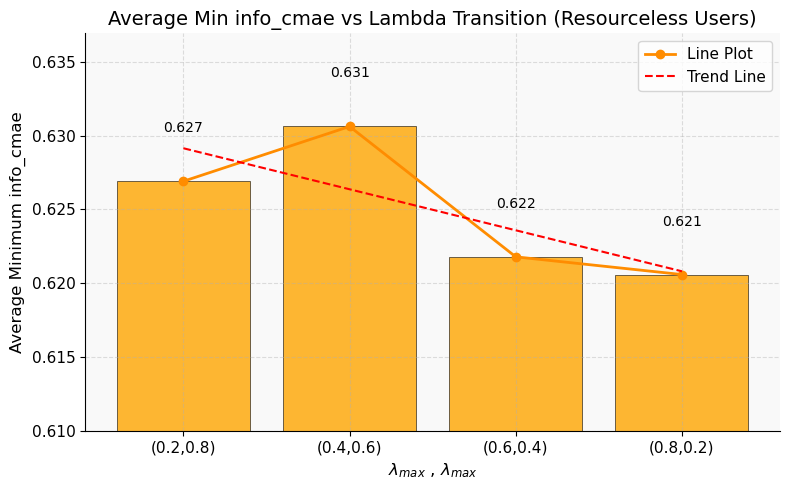

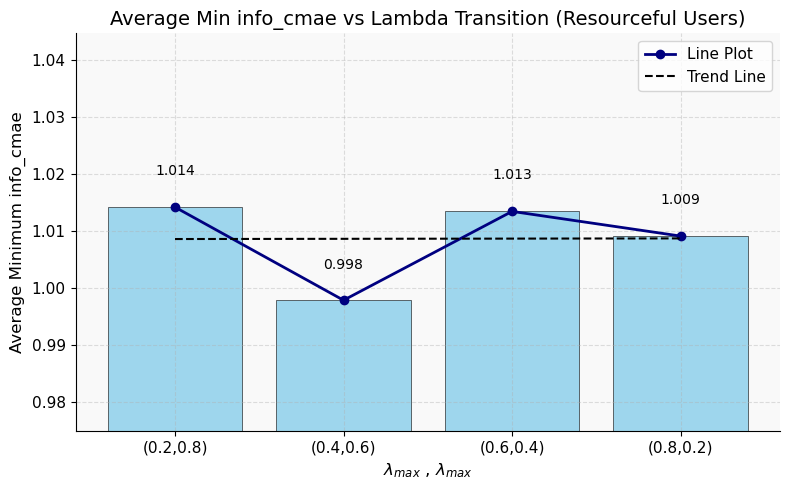

In [2]:
import os
import glob
import json
import numpy as np
import matplotlib.pyplot as plt

# ───────────────────────────────────────────────────────────────
# CONFIGURATION
# ───────────────────────────────────────────────────────────────
base_dir = "/proj/sourasb-220503/TCSS-DIPA2/Fed-DIPA2/results/client_level"
lambda_pairs = [(0.2, 0.8), (0.4, 0.6), (0.6, 0.4), (0.8, 0.2)]
folder_template = "CFedDC_lambda_min_{:.1f}_lambda_max_{:.1f}_kappa_1.0_delta_1.0"

plt.rcParams.update({
    "axes.titlesize": 14,
    "axes.labelsize": 12,
    "xtick.labelsize": 11,
    "ytick.labelsize": 11,
    "legend.fontsize": 11,
    "font.family": "sans-serif"
})

# ───────────────────────────────────────────────────────────────
# FUNCTION TO COMPUTE AVERAGE MIN info_cmae
# ───────────────────────────────────────────────────────────────
def calculate_average_min_info_cmae(file_list):
    min_values = []
    for file_path in file_list:
        try:
            with open(file_path, 'r') as json_file:
                file_data = json.load(json_file)
                info_cmae = file_data.get('validation_results', {}).get('info_cmae', [])
                if info_cmae:
                    min_values.append(min(info_cmae))
        except Exception as e:
            print(f"Error reading {file_path}: {e}")
    return sum(min_values) / len(min_values) if min_values else np.nan

# ───────────────────────────────────────────────────────────────
# LOOP THROUGH EACH (lambda_min, lambda_max)
# ───────────────────────────────────────────────────────────────
x_labels = []
avg_rf = []
avg_rl = []

for lambda_min, lambda_max in lambda_pairs:
    folder_name = folder_template.format(lambda_min, lambda_max)
    directory_path = os.path.join(base_dir, folder_name, "local_test")
    file_list = glob.glob(os.path.join(directory_path, "*.json"))

    resourceless_files = []
    resourceful_files = []

    for file_path in file_list:
        try:
            with open(file_path, 'r') as json_file:
                data = json.load(json_file)
                category = data.get('resource_category')
                if category == 'Resourceless user':
                    resourceless_files.append(file_path)
                elif category == 'Resourceful user':
                    resourceful_files.append(file_path)
        except Exception as e:
            print(f"Error processing {file_path}: {e}")

    avg_rf.append(calculate_average_min_info_cmae(resourceful_files))
    avg_rl.append(calculate_average_min_info_cmae(resourceless_files))
    x_labels.append(f"({lambda_min:.1f},{lambda_max:.1f})")

# ───────────────────────────────────────────────────────────────
# PLOT FUNCTION (Reusable with NaN-safe trend line)
# ───────────────────────────────────────────────────────────────
def plot_with_annotations(x_vals, values, title, color_bar, color_line, color_trend, ylabel, ylim_range):
    fig, ax = plt.subplots(figsize=(8, 5))

    bars = ax.bar(x_vals, values, alpha=0.8, color=color_bar, edgecolor='black', linewidth=0.5)
    ax.plot(x_vals, values, marker='o', color=color_line, linewidth=2, label="Line Plot")

    # Safe trend line fitting
    x_numeric = np.arange(len(x_vals))
    values_np = np.array(values)
    mask = ~np.isnan(values_np)
    if np.sum(mask) >= 2:  # Fit only if enough valid points
        coef = np.polyfit(x_numeric[mask], values_np[mask], 1)
        trend_func = np.poly1d(coef)
        x_fit = np.linspace(0, len(x_vals) - 1, 100)
        y_fit = trend_func(x_fit)
        ax.plot(x_fit, y_fit, linestyle='--', color=color_trend, linewidth=1.5, label="Trend Line")

    # Annotate bars
    for bar in bars:
        yval = bar.get_height()
        if not np.isnan(yval):
            ax.text(bar.get_x() + bar.get_width()/2.0, yval + (0.005 * yval), f"{yval:.3f}", ha='center', va='bottom', fontsize=10)

    ax.set_title(title)
    ax.set_xlabel("$\lambda_{max}$ , $\lambda_{max}$")
    ax.set_ylabel(ylabel)
    ax.set_ylim(ylim_range)
    ax.grid(True, linestyle='--', alpha=0.4)
    ax.set_facecolor('#f9f9f9')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xticks(range(len(x_vals)))
    ax.set_xticklabels(x_vals)
    ax.legend()
    plt.tight_layout()
    plt.show()

# ───────────────────────────────────────────────────────────────
# PLOT FIGURE 1: RESOURCELESS USERS
# ───────────────────────────────────────────────────────────────
plot_with_annotations(
    x_vals=x_labels,
    values=avg_rl,
    title="Average Min info_cmae vs Lambda Transition (Resourceless Users)",
    color_bar='orange',
    color_line='darkorange',
    color_trend='red',
    ylabel="Average Minimum info_cmae",
    ylim_range=(0.61, max([v for v in avg_rl if not np.isnan(v)]) * 1.01)
)

# ───────────────────────────────────────────────────────────────
# PLOT FIGURE 2: RESOURCEFUL USERS
# ───────────────────────────────────────────────────────────────
plot_with_annotations(
    x_vals=x_labels,
    values=avg_rf,
    title="Average Min info_cmae vs Lambda Transition (Resourceful Users)",
    color_bar='skyblue',
    color_line='navy',
    color_trend='black',
    ylabel="Average Minimum info_cmae",
    ylim_range=(0.975, max([v for v in avg_rf if not np.isnan(v)]) * 1.03)
)



Processing folder: CFedDC_lambda_min_0.2_lambda_max_0.8_kappa_1.0_delta_1.0
Processing folder: CFedDC_lambda_min_0.4_lambda_max_0.6_kappa_1.0_delta_1.0
Processing folder: CFedDC_lambda_min_0.6_lambda_max_0.4_kappa_1.0_delta_1.0
Processing folder: CFedDC_lambda_min_0.8_lambda_max_0.2_kappa_1.0_delta_1.0
Common rounds across folders: 30
Plotting full range: 10 rounds


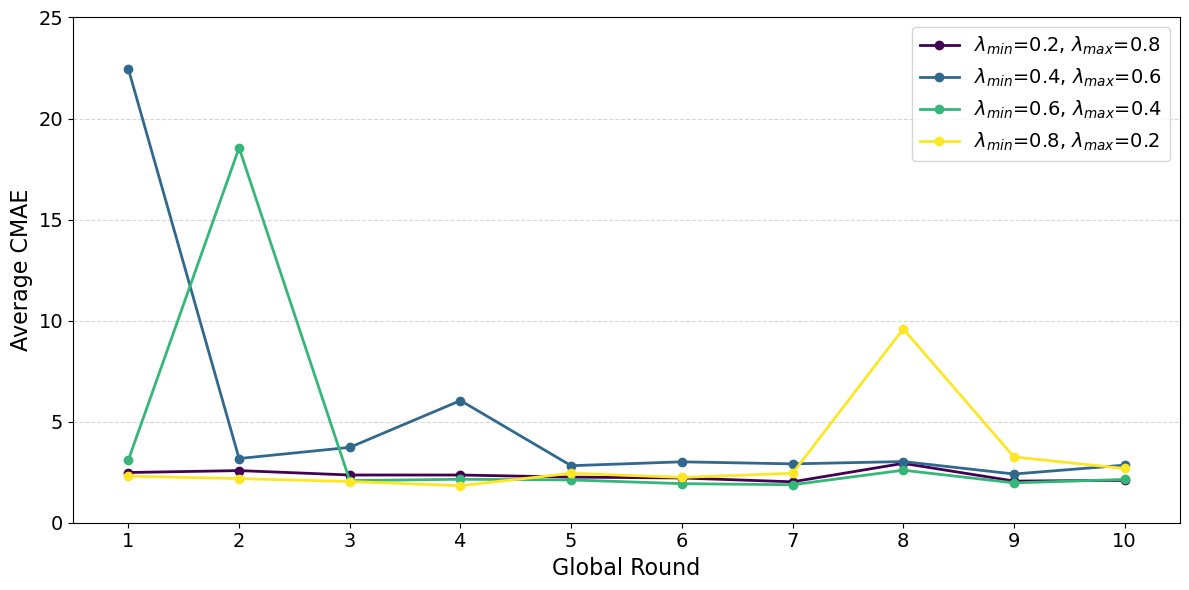

Saved lineplot of average CMAE with full legend at:
    /proj/sourasb-220503/TCSS-DIPA2/Fed-DIPA2/results/client_level/all_mae/resourceless_avg_cmae_CFedDC_lambda_legend_full.png


In [6]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# ─── CONFIGURATION ────────────────────────────────────────────────────────────
base_dir  = "/proj/sourasb-220503/TCSS-DIPA2/Fed-DIPA2/results/client_level"

folders = [
    "CFedDC_lambda_min_0.2_lambda_max_0.8_kappa_1.0_delta_1.0",
    "CFedDC_lambda_min_0.4_lambda_max_0.6_kappa_1.0_delta_1.0",
    "CFedDC_lambda_min_0.6_lambda_max_0.4_kappa_1.0_delta_1.0",
    "CFedDC_lambda_min_0.8_lambda_max_0.2_kappa_1.0_delta_1.0"
]

num_users = 535

# ─── STEP 1: COLLECT DATA ──────────────────────────────────────────────────────
cmae_lists = { folder: [] for folder in folders }

for folder in folders:
    print(f"Processing folder: {folder}")
    for user_id in range(num_users):
        filename = f"user_{user_id}_val_round_results.json"
        file_path = os.path.join(base_dir, folder, "local_val", filename)

        if not os.path.exists(file_path):
            continue

        try:
            with open(file_path, "r") as f:
                data = json.load(f)
        except Exception as e:
            print(f"[Warning] Could not read {file_path}: {e}")
            continue

        # RESOURCELESS ONLY
        rc = data.get("resource_category", "Unknown").replace(" user", "").lower()
        if rc != "resourceless":
            continue

        cmae = data.get("validation_results", {}).get("info_cmae", [])
        if not cmae:
            continue

        cmae_lists[folder].append(cmae)

# ─── STEP 2: ORGANIZE DATA BY ROUND ────────────────────────────────────────────
for folder in folders:
    if len(cmae_lists[folder]) == 0:
        raise RuntimeError(f"No resourceless users found for {folder}.")

max_rounds_per_folder = [max(len(lst) for lst in cmae_lists[folder]) for folder in folders]
common_rounds = min(max_rounds_per_folder)
print(f"Common rounds across folders: {common_rounds}")

plot_rounds = min(common_rounds, 10)
print(f"Plotting full range: {plot_rounds} rounds")

by_round = {}
for folder in folders:
    by_round[folder] = [[] for _ in range(common_rounds)]
    for user_list in cmae_lists[folder]:
        for r in range(len(user_list)):
            if r < common_rounds:
                by_round[folder][r].append(user_list[r])

# ─── STEP 3: PLOT AVERAGE CMAE + STD SHADING ───────────────────────────────────
plt.figure(figsize=(12, 6))
rounds = np.arange(1, plot_rounds + 1)

# Use a colormap → Viridis
cmap = plt.get_cmap("viridis")
n = len(folders)
colors = [cmap(i / (n - 1)) for i in range(n)]

for idx, folder in enumerate(folders):
    avg_cmae = []
    std_cmae = []
    for r in range(plot_rounds):
        round_values = by_round[folder][r]
        mean_val = np.mean(round_values)
        std_val  = np.std(round_values)
        avg_cmae.append(mean_val)
        std_cmae.append(std_val)

    # Parse lambda_min and lambda_max for legend
    parts = folder.split('_')
    lambda_min = parts[3]
    lambda_max = parts[6]
    label = f"$\lambda_{{min}}$={lambda_min}, $\\lambda_{{max}}$={lambda_max}"

    # Plot average line
    plt.plot(
        rounds,
        avg_cmae,
        label=label,
        color=colors[idx],
        linewidth=2,
        marker='o',
        markersize=6
    )

    # (Optional) Plot std shading
    # Uncomment below to include error bands
    # avg_cmae = np.array(avg_cmae)
    # std_cmae = np.array(std_cmae)
    # plt.fill_between(
    #     rounds,
    #     avg_cmae - std_cmae,
    #     avg_cmae + std_cmae,
    #     color=colors[idx],
    #     alpha=0.2
    # )

# X-axis
plt.xticks(rounds, [str(r) for r in rounds], fontsize=14)
plt.xlim(0.5, plot_rounds + 0.5)

# Labels
plt.xlabel("Global Round", fontsize=16)
plt.ylabel("Average CMAE", fontsize=16)
plt.yticks(fontsize=14)
plt.ylim(0.0, 25.0)
plt.grid(axis="y", linestyle="--", alpha=0.5)

# Legend
plt.legend(fontsize=14, loc="upper right")

plt.tight_layout()

# Save
save_path = os.path.join(base_dir, "all_mae", "resourceless_avg_cmae_CFedDC_lambda_legend_full.png")
os.makedirs(os.path.dirname(save_path), exist_ok=True)
plt.savefig(save_path)
plt.show()
plt.close()

print(f"Saved lineplot of average CMAE with full legend at:\n    {save_path}")


Processing folder: CFedDC_lambda_min_0.2_lambda_max_0.8_kappa_1.0_delta_1.0
Processing folder: CFedDC_lambda_min_0.4_lambda_max_0.6_kappa_1.0_delta_1.0
Processing folder: CFedDC_lambda_min_0.6_lambda_max_0.4_kappa_1.0_delta_1.0
Processing folder: CFedDC_lambda_min_0.8_lambda_max_0.2_kappa_1.0_delta_1.0
Common rounds across folders: 30
Plotting full range: 10 rounds


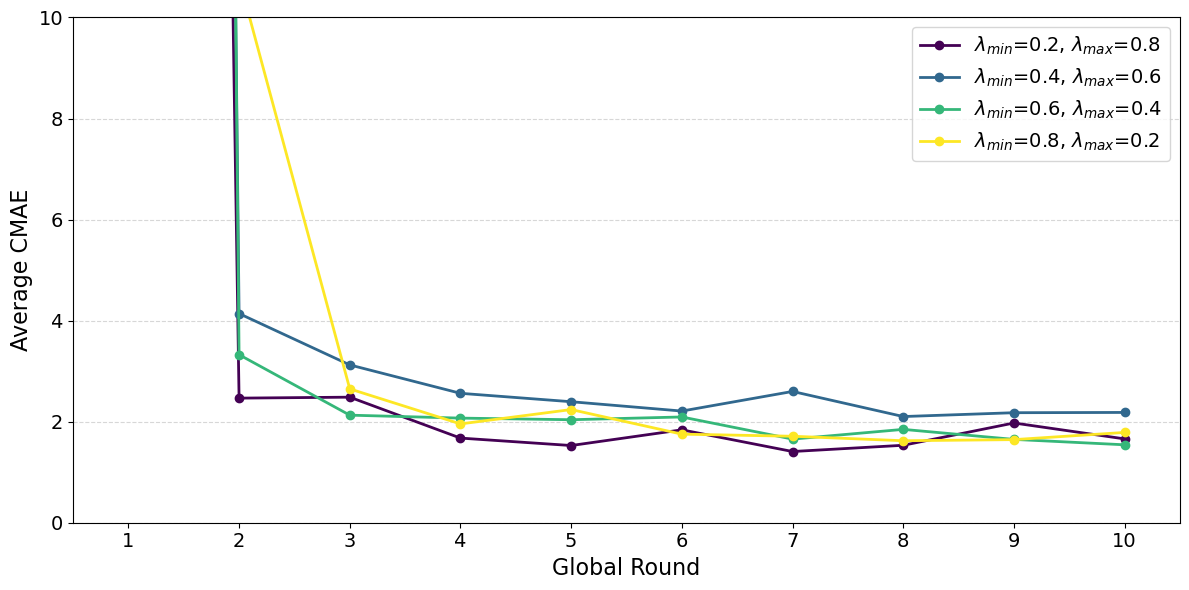

Saved lineplot of average CMAE with legend at:
    /proj/sourasb-220503/TCSS-DIPA2/Fed-DIPA2/results/client_level/all_mae/resourceful_avg_cmae_CFedDC_lambda_full_lineplot.png


In [4]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# ─── CONFIGURATION ────────────────────────────────────────────────────────────
base_dir  = "/proj/sourasb-220503/TCSS-DIPA2/Fed-DIPA2/results/client_level"

folders = [
    "CFedDC_lambda_min_0.2_lambda_max_0.8_kappa_1.0_delta_1.0",
    "CFedDC_lambda_min_0.4_lambda_max_0.6_kappa_1.0_delta_1.0",
    "CFedDC_lambda_min_0.6_lambda_max_0.4_kappa_1.0_delta_1.0",
    "CFedDC_lambda_min_0.8_lambda_max_0.2_kappa_1.0_delta_1.0"
]

num_users = 535

# ─── STEP 1: COLLECT DATA ──────────────────────────────────────────────────────
cmae_lists = {folder: [] for folder in folders}

for folder in folders:
    print(f"Processing folder: {folder}")
    for user_id in range(num_users):
        filename = f"user_{user_id}_val_round_results.json"
        file_path = os.path.join(base_dir, folder, "local_val", filename)

        if not os.path.exists(file_path):
            continue

        try:
            with open(file_path, "r") as f:
                data = json.load(f)
        except Exception as e:
            print(f"[Warning] Could not read {file_path}: {e}")
            continue

        rc = data.get("resource_category", "Unknown").replace(" user", "").lower()
        if rc != "resourceful":
            continue

        cmae = data.get("validation_results", {}).get("info_cmae", [])
        if cmae:
            cmae_lists[folder].append(cmae)

# ─── STEP 2: ORGANIZE DATA BY ROUND ────────────────────────────────────────────
for folder in folders:
    if len(cmae_lists[folder]) == 0:
        raise RuntimeError(f"No resourceful users found for {folder}.")

max_rounds_per_folder = [max(len(lst) for lst in cmae_lists[folder]) for folder in folders]
common_rounds = min(max_rounds_per_folder)
print(f"Common rounds across folders: {common_rounds}")

plot_rounds = min(common_rounds, 10)
print(f"Plotting full range: {plot_rounds} rounds")

by_round = {}
for folder in folders:
    by_round[folder] = [[] for _ in range(common_rounds)]
    for user_list in cmae_lists[folder]:
        for r in range(len(user_list)):
            if r < common_rounds:
                by_round[folder][r].append(user_list[r])

# ─── STEP 3: PLOT AVERAGE CMAE + STD SHADING ───────────────────────────────────
plt.figure(figsize=(12, 6))
rounds = np.arange(1, plot_rounds + 1)

# Use a nice colormap → Viridis, one color per folder
cmap = plt.get_cmap("viridis")
n = len(folders)
colors = [cmap(i / (n - 1)) for i in range(n)]

for idx, folder in enumerate(folders):
    avg_cmae = []
    std_cmae = []
    for r in range(plot_rounds):
        round_values = by_round[folder][r]
        mean_val = np.mean(round_values)
        std_val = np.std(round_values)
        avg_cmae.append(mean_val)
        std_cmae.append(std_val)

    # Parse lambda value
    parts = folder.split('_')
      # Parse lambda_min and lambda_max for legend
    parts = folder.split('_')
    lambda_min = parts[3]
    lambda_max = parts[6]
    label = f"$\lambda_{{min}}$={lambda_min}, $\\lambda_{{max}}$={lambda_max}"

    # Plot average line
    plt.plot(
        rounds,
        avg_cmae,
        label=label,
        color=colors[idx],
        linewidth=2,
        marker='o',
        markersize=6
    )

    # (Optional) Plot std shading
    # avg_cmae = np.array(avg_cmae)
    # std_cmae = np.array(std_cmae)
    # plt.fill_between(
    #     rounds,
    #     avg_cmae - std_cmae,
    #     avg_cmae + std_cmae,
    #     color=colors[idx],
    #     alpha=0.2
    # )

# ─── Final Plot Setup ──────────────────────────────────────────────────────────
plt.xticks(rounds, [str(r) for r in rounds], fontsize=14)
plt.xlim(0.5, plot_rounds + 0.5)
plt.xlabel("Global Round", fontsize=16)
plt.ylabel("Average CMAE", fontsize=16)
plt.yticks(fontsize=14)
plt.ylim(0.0, 10.0)
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.legend(fontsize=14, loc="upper right")
plt.tight_layout()

# ─── Save Plot ─────────────────────────────────────────────────────────────────
save_path = os.path.join(base_dir, "all_mae", "resourceful_avg_cmae_CFedDC_lambda_full_lineplot.png")
os.makedirs(os.path.dirname(save_path), exist_ok=True)
plt.savefig(save_path)
plt.show()
plt.close()

print(f"Saved lineplot of average CMAE with legend at:\n    {save_path}")

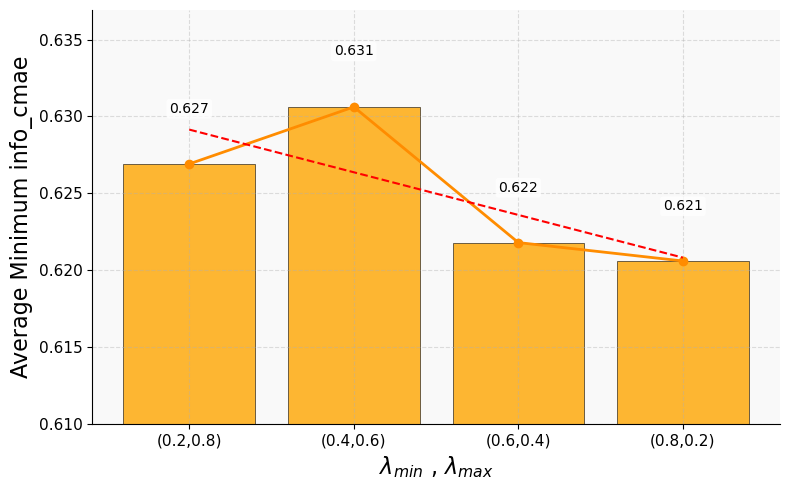

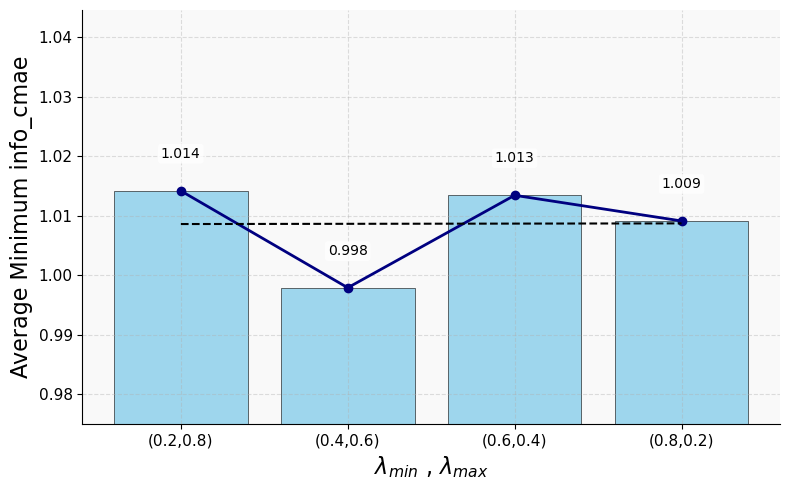

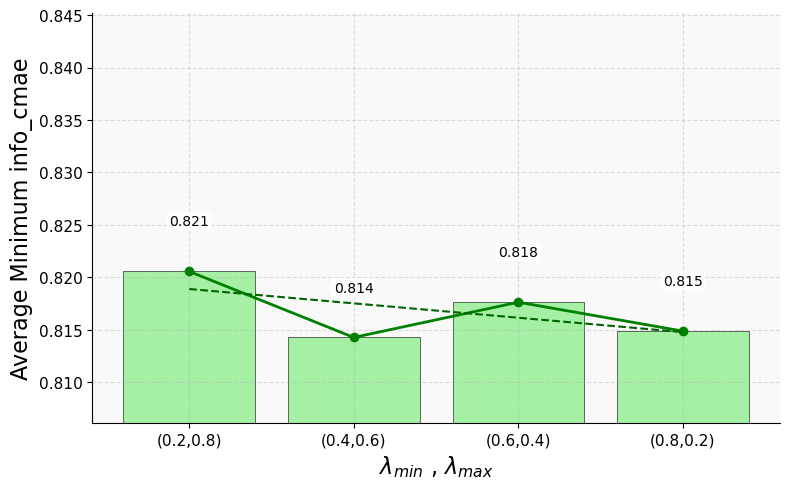

In [8]:
import os
import glob
import json
import numpy as np
import matplotlib.pyplot as plt

# ───────────────────────────────────────────────────────────────
# CONFIGURATION
# ───────────────────────────────────────────────────────────────
base_dir = "/proj/sourasb-220503/TCSS-DIPA2/Fed-DIPA2/results/client_level"
lambda_pairs = [(0.2, 0.8), (0.4, 0.6), (0.6, 0.4), (0.8, 0.2)]
folder_template = "CFedDC_lambda_min_{:.1f}_lambda_max_{:.1f}_kappa_1.0_delta_1.0"

plt.rcParams.update({
    "axes.titlesize": 14,
    "axes.labelsize": 12,
    "xtick.labelsize": 11,
    "ytick.labelsize": 11,
    "legend.fontsize": 11,
    "font.family": "sans-serif"
})

# ───────────────────────────────────────────────────────────────
# FUNCTION TO COMPUTE AVERAGE MIN info_cmae
# ───────────────────────────────────────────────────────────────
def calculate_average_min_info_cmae(file_list):
    min_values = []
    for file_path in file_list:
        try:
            with open(file_path, 'r') as json_file:
                file_data = json.load(json_file)
                info_cmae = file_data.get('validation_results', {}).get('info_cmae', [])
                if info_cmae:
                    min_values.append(min(info_cmae))
        except Exception as e:
            print(f"Error reading {file_path}: {e}")
    return sum(min_values) / len(min_values) if min_values else np.nan

# ───────────────────────────────────────────────────────────────
# COLLECT AVERAGE CMAE FOR EACH CATEGORY
# ───────────────────────────────────────────────────────────────
x_labels = []
avg_rf = []
avg_rl = []

for lambda_min, lambda_max in lambda_pairs:
    folder_name = folder_template.format(lambda_min, lambda_max)
    directory_path = os.path.join(base_dir, folder_name, "local_test")
    file_list = glob.glob(os.path.join(directory_path, "*.json"))

    resourceless_files = []
    resourceful_files = []

    for file_path in file_list:
        try:
            with open(file_path, 'r') as json_file:
                data = json.load(json_file)
                category = data.get('resource_category')
                if category == 'Resourceless user':
                    resourceless_files.append(file_path)
                elif category == 'Resourceful user':
                    resourceful_files.append(file_path)
        except Exception as e:
            print(f"Error processing {file_path}: {e}")

    avg_rf.append(calculate_average_min_info_cmae(resourceful_files))
    avg_rl.append(calculate_average_min_info_cmae(resourceless_files))
    x_labels.append(f"({lambda_min:.1f},{lambda_max:.1f})")

# Compute overall average (for all users)
avg_all = [(rf + rl) / 2 if not (np.isnan(rf) or np.isnan(rl)) else np.nan
           for rf, rl in zip(avg_rf, avg_rl)]

# ───────────────────────────────────────────────────────────────
# PLOT FUNCTION
# ───────────────────────────────────────────────────────────────
def plot_with_annotations(x_vals, values, title, color_bar, color_line, color_trend, ylabel, ylim_range):
    fig, ax = plt.subplots(figsize=(8, 5))

    bars = ax.bar(x_vals, values, alpha=0.8, color=color_bar, edgecolor='black', linewidth=0.5)
    ax.plot(x_vals, values, marker='o', color=color_line, linewidth=2, label="Line Plot")

    x_numeric = np.arange(len(x_vals))
    values_np = np.array(values)
    mask = ~np.isnan(values_np)
    if np.sum(mask) >= 2:
        coef = np.polyfit(x_numeric[mask], values_np[mask], 1)
        trend_func = np.poly1d(coef)
        x_fit = np.linspace(0, len(x_vals) - 1, 100)
        y_fit = trend_func(x_fit)
        ax.plot(x_fit, y_fit, linestyle='--', color=color_trend, linewidth=1.5, label="Trend Line")

    for bar in bars:
        yval = bar.get_height()
        if not np.isnan(yval):
            ax.text(bar.get_x() + bar.get_width()/2.0, yval + (0.005 * yval), f"{yval:.3f}", 
                    ha='center', va='bottom', fontsize=10,
                    bbox=dict(boxstyle="round,pad=0.2", edgecolor='none', facecolor='white', alpha=0.8))

    # ax.set_title(title)
    ax.set_xlabel("$\lambda_{min}$ , $\lambda_{max}$", fontsize=16)
    ax.set_ylabel(ylabel, fontsize=16)
    ax.set_ylim(ylim_range)
    ax.grid(True, linestyle='--', alpha=0.4)
    ax.set_facecolor('#f9f9f9')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xticks(range(len(x_vals)))
    ax.set_xticklabels(x_vals)
    # ax.legend()
    plt.tight_layout()
    plt.show()

# ───────────────────────────────────────────────────────────────
# PLOTS
# ───────────────────────────────────────────────────────────────
plot_with_annotations(
    x_vals=x_labels,
    values=avg_rl,
    title="Average Min info_cmae vs Lambda Transition (Resourceless Users)",
    color_bar='orange',
    color_line='darkorange',
    color_trend='red',
    ylabel="Average Minimum info_cmae",
    ylim_range=(0.61, max([v for v in avg_rl if not np.isnan(v)]) * 1.01)
)

plot_with_annotations(
    x_vals=x_labels,
    values=avg_rf,
    title="Average Min info_cmae vs Lambda Transition (Resourceful Users)",
    color_bar='skyblue',
    color_line='navy',
    color_trend='black',
    ylabel="Average Minimum info_cmae",
    ylim_range=(0.975, max([v for v in avg_rf if not np.isnan(v)]) * 1.03)
)

plot_with_annotations(
    x_vals=x_labels,
    values=avg_all,
    title="Average Min info_cmae vs Lambda Transition (All Users)",
    color_bar='lightgreen',
    color_line='green',
    color_trend='darkgreen',
    ylabel="Average Minimum info_cmae",
    ylim_range=(min([v for v in avg_all if not np.isnan(v)]) * 0.99,
                max([v for v in avg_all if not np.isnan(v)]) * 1.03)
)
